In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df =  pd.DataFrame()

for i in np.arange(0.75, 3,0.1):
    first = 3*np.sin(np.arange(0,20,0.1)/6.28) 
    second = 3*np.sin(np.arange(0,20,0.1)/6.28)+0.5 
    third = 3*np.sin(np.arange(0,20,0.1)/6.28)+0.65 

    rolling = pd.DataFrame()
    elevation = np.full(200, i) #+np.random.rand(200)/100
    first = np.where(first > elevation, elevation, first)
    second = np.where(second > elevation, elevation, second)
    third = np.where(third > elevation, elevation, third)

    rolling['elevation'] = elevation
    rolling['third'] = third
    rolling['second'] = second
    rolling['firsts'] = first
    df = pd.concat((df, rolling))

In [3]:
angular_thicknesses = df.T.diff(axis=0).abs().T
angular_thicknesses['mean'] = angular_thicknesses.copy().mean(axis=1)
angular_thicknesses['third_lag'] = angular_thicknesses.third.shift(np.random.randint(5))
angular_thicknesses['second_lag'] = angular_thicknesses.second.shift(np.random.randint(5))
angular_thicknesses['first_lag'] =angular_thicknesses.firsts.shift(np.random.randint(5))

angular_thicknesses = angular_thicknesses.drop(columns=['elevation']).dropna()


In [4]:
df_onlap = pd.DataFrame()
for i in np.arange(0.75, 3, 0.1):
    
    elevation = np.full(200, i) #+np.random.rand(200)/100
    onlap_first = np.where(3*np.sin(np.arange(0,20,0.1)/6.28) > elevation, elevation, 3*np.sin(np.arange(0,20,0.1)/6.28))
    onlap_second = np.where(np.where(np.full(200,1.5) > onlap_first, np.full(200,0.5), onlap_first) > elevation, elevation, np.where(np.full(200,0.5) > onlap_first, np.full(200,0.5), onlap_first))
    onlap_third = np.where(np.where(np.full(200,1.65) > onlap_first, np.full(200,0.65), onlap_first) > elevation, elevation, np.where(np.full(200,0.65) > onlap_first, np.full(200,0.65), onlap_first))
    rolling_onlap = pd.DataFrame()
    rolling_onlap['elevation'] = elevation
    rolling_onlap['third'] = onlap_third
    rolling_onlap['second'] = onlap_second
    rolling_onlap['firsts'] = onlap_first
    df_onlap = pd.concat((df, rolling_onlap))


In [5]:
onlap_thicknesses = df_onlap.T.diff(axis=0).abs().T
onlap_thicknesses['mean'] = onlap_thicknesses.copy().mean(axis=1)
onlap_thicknesses['third_lag'] = onlap_thicknesses.third.shift(np.random.randint(5))
onlap_thicknesses['second_lag'] = onlap_thicknesses.second.shift(np.random.randint(5))
onlap_thicknesses['first_lag'] =onlap_thicknesses.firsts.shift(np.random.randint(5))

onlap_thicknesses = onlap_thicknesses.drop(columns=['elevation']).dropna()


In [6]:

df_horizontal = pd.DataFrame()

for i in np.arange(0.75, 3, 0.1):
    horizontal_first = np.full(200, 0)+np.random.rand(200)/10
    horizontal_second = np.full(200, 1.5)+np.random.rand(200)/10
    horizontal_third = np.full(200,1.65)+np.random.rand(200)/10

    rolling_horiz =  pd.DataFrame()
    rolling_horiz['elevation'] = elevation
    rolling_horiz['third'] = horizontal_third
    rolling_horiz['second'] = horizontal_second
    rolling_horiz['firsts'] = horizontal_first
    df_horiz = pd.concat((df, rolling_horiz))



In [7]:

horizontal_thicknesses = df_horiz.T.diff(axis=0).abs().T
horizontal_thicknesses['mean'] = horizontal_thicknesses.copy().mean(axis=1)
horizontal_thicknesses['third_lag'] = horizontal_thicknesses.third.shift(3)
horizontal_thicknesses['second_lag'] = horizontal_thicknesses.second.shift(3)
horizontal_thicknesses['first_lag'] =horizontal_thicknesses.firsts.shift(3)

horizontal_thicknesses = horizontal_thicknesses.drop(columns=['elevation']).dropna()


In [8]:
normalized_df=(angular_thicknesses-angular_thicknesses.min())/(angular_thicknesses.max()-angular_thicknesses.min())
normalized_dfo=(onlap_thicknesses-onlap_thicknesses.min())/(onlap_thicknesses.max()-onlap_thicknesses.min())
normalized_dfh=(horizontal_thicknesses-horizontal_thicknesses.min())/(horizontal_thicknesses.max()-horizontal_thicknesses.min())

normalized_dfo['class'] = 1
normalized_df['class'] = 0
normalized_dfh['class'] = 2

In [9]:
dataset = pd.concat((normalized_df, normalized_dfo, normalized_dfh))

In [10]:
dataset.max()

third         1.0
second        1.0
firsts        1.0
mean          1.0
third_lag     1.0
second_lag    1.0
first_lag     1.0
class         2.0
dtype: float64

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[0:,0:7].values, dataset.iloc[0:,7].values, test_size=0.1, random_state=86)

In [12]:
from keras.utils import to_categorical
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

In [14]:
model = Sequential()
model.add(Dense(1000, input_shape=(7,), kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='sigmoid'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [15]:
model.fit(X_train, y_train_encoded, epochs=100, batch_size=128)

Epoch 1/100
12771/12771 [==============================] - 1s 48us/step - loss: 1.0639 - acc: 0.3698
Epoch 2/100
12771/12771 [==============================] - 0s 31us/step - loss: 1.0007 - acc: 0.4560
Epoch 3/100
12771/12771 [==============================] - 0s 34us/step - loss: 0.9825 - acc: 0.4737
Epoch 4/100
12771/12771 [==============================] - 0s 30us/step - loss: 0.9741 - acc: 0.4745
Epoch 5/100
12771/12771 [==============================] - 0s 34us/step - loss: 0.9686 - acc: 0.4765
Epoch 6/100
12771/12771 [==============================] - 0s 31us/step - loss: 0.9646 - acc: 0.4779
Epoch 7/100
12771/12771 [==============================] - 0s 35us/step - loss: 0.9584 - acc: 0.4809
Epoch 8/100
12771/12771 [==============================] - 0s 35us/step - loss: 0.9447 - acc: 0.4854
Epoch 9/100
12771/12771 [==============================] - 0s 35us/step - loss: 0.9365 - acc: 0.4852
Epoch 10/100
12771/12771 [==============================] - 0s 35us/step - loss: 0.9271 - a

12771/12771 [==============================] - 0s 25us/step - loss: 0.6044 - acc: 0.6487
Epoch 82/100
12771/12771 [==============================] - 0s 21us/step - loss: 0.6061 - acc: 0.6496
Epoch 83/100
12771/12771 [==============================] - 0s 20us/step - loss: 0.6045 - acc: 0.6482
Epoch 84/100
12771/12771 [==============================] - 0s 19us/step - loss: 0.6037 - acc: 0.6501
Epoch 85/100
12771/12771 [==============================] - 0s 19us/step - loss: 0.6013 - acc: 0.6508
Epoch 86/100
12771/12771 [==============================] - 0s 19us/step - loss: 0.6008 - acc: 0.6526
Epoch 87/100
12771/12771 [==============================] - 0s 19us/step - loss: 0.6007 - acc: 0.6527
Epoch 88/100
12771/12771 [==============================] - 0s 19us/step - loss: 0.5993 - acc: 0.6527
Epoch 89/100
12771/12771 [==============================] - 0s 19us/step - loss: 0.6001 - acc: 0.6492
Epoch 90/100
12771/12771 [==============================] - 0s 19us/step - loss: 0.6007 - acc: 

In [16]:
score=model.evaluate(X_test, y_test_encoded)
score

1419/1419 [==============================] - 0s 41us/step


[0.6002681591798085, 0.6575052853282528]

In [17]:
preds = model.predict(X_test)

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


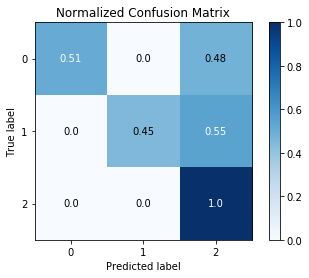

In [18]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, np.argmax(preds, axis=1), normalize=True)

